# Geothermal Well 58-32 Lithology Prediction

In [1]:
# import some relevant libraries to begin exploratory analysis of the dataset
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import pandas as pd
from math import ceil
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer

In [2]:
# get drilling data
drilling = pd.read_csv('Well_58-32_processed_pason_log_drilling data.csv')

In [3]:
drilling.head()

,Depth(ft),Depth(m),ROP(1 ft),ROP(1 m),weight on bit (k-lbs),weight on bit (kg),Temp Out( degF),Temp Out( degC),Temp In(degF),Temp In(degC),...,Surface Torque (KPa),Rotary Speed (rpm),Flow In (gal/min),Flow In(liters/min),Flow Out %,WH Pressure (psi),WH Pressure (KPa),H2S Floor,H2S Cellar,H2S Pits
0,85.18,25.96,56.80,17.31,0.0,0.0,93.49,34.16,90.87,32.71,...,61.57,151.09,1109.58,4200.22,101.61,-1230.69,-8485.61,-0.01,-0.03,0.31
1,86.18,26.27,61.14,18.63,0.0,0.0,93.52,34.18,90.83,32.68,...,61.57,151.09,1108.36,4195.60,101.70,-1230.69,-8485.61,-0.01,-0.04,0.31
2,87.23,26.59,18.58,5.66,0.0,0.0,94.25,34.58,90.91,32.73,...,62.12,61.54,1102.87,4174.82,96.81,-1230.69,-8485.61,-0.01,-0.03,0.30
3,88.26,26.90,38.29,11.67,0.0,0.0,94.44,34.69,91.14,32.86,...,61.85,60.23,1101.04,4167.89,96.67,-1230.69,-8485.61,0.00,-0.03,0.31
4,89.36,27.24,394.38,120.20,0.0,0.0,94.48,34.71,91.18,32.88,...,61.85,61.75,1102.46,4173.26,96.63,-1230.69,-8485.61,-0.02,-0.02,0.31


In [4]:
drilling.columns

Index(['Depth(ft)', 'Depth(m)', 'ROP(1 ft)', 'ROP(1 m)',
       'weight on bit (k-lbs)', 'weight on bit (kg)', 'Temp Out( degF)',
       'Temp Out( degC)', 'Temp In(degF)', 'Temp In(degC)', 'Pit Total (bbls)',
       'Pit Total (m3)', 'Pump Press (psi)', 'Pump Press (KPa)',
       'Hookload (k-lbs)', 'Hookload (kg)', 'Surface Torque (psi)',
       'Surface Torque (KPa)', 'Rotary Speed (rpm)', 'Flow In (gal/min)',
       'Flow In(liters/min)', 'Flow Out %', 'WH Pressure (psi)',
       'WH Pressure (KPa)', 'H2S Floor', 'H2S Cellar', 'H2S Pits'],
      dtype='object')

## Select Required Features
- Depth(ft)
- ROP(1 ft)
- Rotary Speed (rpm)
- Surface Torque (psi)
- Flow In (gal/min)
- Pump Press (psi)

In [5]:
drill_df = pd.DataFrame(drilling, columns=['Depth(ft)', 'ROP(1 ft)', 'Rotary Speed (rpm)', 
                                           'Surface Torque (psi)', 'Flow In (gal/min)', 
                                           'Pump Press (psi)'])

In [6]:
drill_df.head()

,Depth(ft),ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi)
0,85.18,56.80,151.09,8.93,1109.58,463.72
1,86.18,61.14,151.09,8.93,1108.36,459.53
2,87.23,18.58,61.54,9.01,1102.87,454.57
3,88.26,38.29,60.23,8.97,1101.04,451.14
4,89.36,394.38,61.75,8.97,1102.46,456.09


In [7]:
drill_df = drill_df.rename(columns={'Depth(ft)': 'DEPTH'})

In [8]:
drill_df.head()

,DEPTH,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi)
0,85.18,56.80,151.09,8.93,1109.58,463.72
1,86.18,61.14,151.09,8.93,1108.36,459.53
2,87.23,18.58,61.54,9.01,1102.87,454.57
3,88.26,38.29,60.23,8.97,1101.04,451.14
4,89.36,394.38,61.75,8.97,1102.46,456.09


### Converting the depth to the nearest whole number

In [9]:
drill_df['DEPTH'] = drill_df['DEPTH'].apply(np.ceil)

In [10]:
drill_df.head()

,DEPTH,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi)
0,86.0,56.80,151.09,8.93,1109.58,463.72
1,87.0,61.14,151.09,8.93,1108.36,459.53
2,88.0,18.58,61.54,9.01,1102.87,454.57
3,89.0,38.29,60.23,8.97,1101.04,451.14
4,90.0,394.38,61.75,8.97,1102.46,456.09


In [11]:
drill_df.shape

(7311, 6)

In [12]:
def actual_lithology(data):
    global litho
    if data['DEPTH'] <= 3176:
        litho = 0
    elif (data['DEPTH'] >= 3176) & (data['DEPTH']  <= 3195):
        litho = 1
    elif (data['DEPTH'] >= 3196) & (data['DEPTH']  <= 7536):
        litho = 2
    return litho

In [13]:
drill_df.head()

,DEPTH,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi)
0,86.0,56.80,151.09,8.93,1109.58,463.72
1,87.0,61.14,151.09,8.93,1108.36,459.53
2,88.0,18.58,61.54,9.01,1102.87,454.57
3,89.0,38.29,60.23,8.97,1101.04,451.14
4,90.0,394.38,61.75,8.97,1102.46,456.09


In [14]:
drill_df.shape

(7311, 6)

In [15]:
drill_df.duplicated().sum()

30

In [16]:
drill_df.drop_duplicates(subset='DEPTH',
                        keep=False, inplace=True)

In [17]:
drill_df.shape

(7235, 6)

### We now Apply the function

In [18]:
drill_df['Lithology'] = drill_df.apply(actual_lithology, axis=1)

In [19]:
drill_df.shape

(7235, 7)

In [20]:
drill_df = drill_df[drill_df['Lithology'] != 1]

In [21]:
drill_df.shape

(7219, 7)

In [22]:
drill_df.Lithology.value_counts()

2    4253
0    2966
Name: Lithology, dtype: int64

In [23]:
drill_df.head()

,DEPTH,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi),Lithology
0,86.0,56.80,151.09,8.93,1109.58,463.72,0
1,87.0,61.14,151.09,8.93,1108.36,459.53,0
2,88.0,18.58,61.54,9.01,1102.87,454.57,0
3,89.0,38.29,60.23,8.97,1101.04,451.14,0
4,90.0,394.38,61.75,8.97,1102.46,456.09,0


In [24]:
drill_df.isna().sum()

DEPTH                   0
ROP(1 ft)               0
Rotary Speed (rpm)      0
Surface Torque (psi)    0
Flow In (gal/min)       0
Pump Press (psi)        0
Lithology               0
dtype: int64

# Getting the data

In [25]:
drill_df = drill_df.iloc[:, 1:]
drill_df.head()

,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi),Lithology
0,56.80,151.09,8.93,1109.58,463.72,0
1,61.14,151.09,8.93,1108.36,459.53,0
2,18.58,61.54,9.01,1102.87,454.57,0
3,38.29,60.23,8.97,1101.04,451.14,0
4,394.38,61.75,8.97,1102.46,456.09,0


In [26]:
drill_df.describe()

,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi),Lithology
count,7219.000000,7219.000000,7219.000000,7219.000000,7219.000000,7219.000000
mean,42.184445,55.054532,131.137777,716.797295,1264.709654,1.178280
std,76.324401,25.960267,48.445601,141.617352,490.935093,0.984048
min,0.000000,0.000000,0.000000,0.000000,19.940000,0.000000
25%,11.430000,38.120000,117.020000,620.260000,664.450000,0.000000
50%,18.000000,50.380000,140.390000,700.230000,1430.520000,2.000000
75%,44.505000,76.100000,157.280000,825.615000,1669.680000,2.000000
max,2977.910000,271.580000,273.710000,3317.510000,2200.430000,2.000000


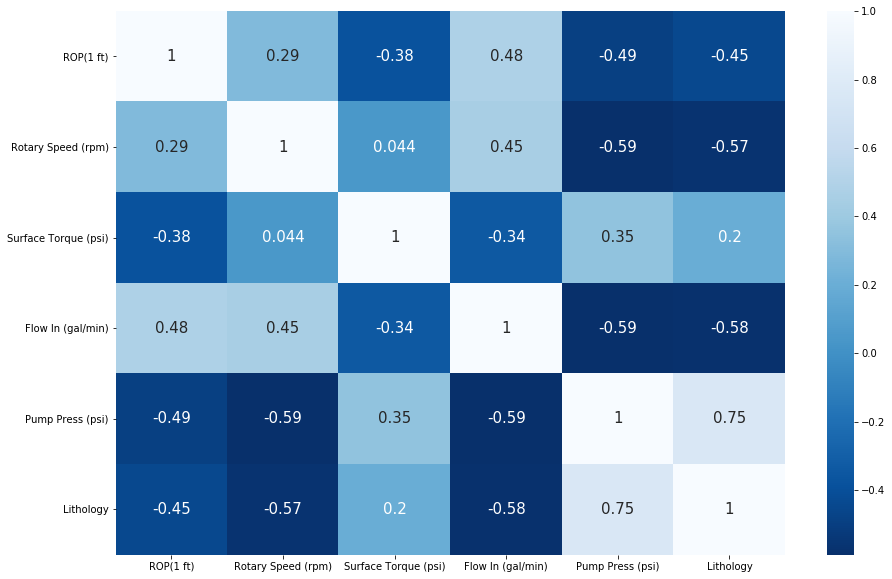

In [27]:
# make a correlation plot (heatmap)
corr_mx = drill_df.corr()
f, ax = plt.subplots(figsize=(15,10)) 
ax = sns.heatmap(corr_mx, annot=True, annot_kws={'size':15}, cmap='Blues_r')

### Training, Validation and Testing Data

We will be using 500 rows (first 250 observations and last 250 observations) for the Testing, which will be kept aside, then use the remaining data for the training and validation set. 

In [28]:
dfTop_250 = drill_df.head(n=250) # first 250 observations
dfDown_250 = drill_df.tail(n=250) # last 250 observations

n = dfTop_250.index[-1] - 1 # index for first obervation training data 
m = dfDown_250.index[0] # index for first obervation training data

df_train = drill_df.iloc[n:m, :] # remaining data for training and validation

In [29]:
n, m # evaluation of the index

(250, 7059)

In [31]:
dfTop_250.head() # display the data

,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi),Lithology
0,56.80,151.09,8.93,1109.58,463.72,0
1,61.14,151.09,8.93,1108.36,459.53,0
2,18.58,61.54,9.01,1102.87,454.57,0
3,38.29,60.23,8.97,1101.04,451.14,0
4,394.38,61.75,8.97,1102.46,456.09,0


In [32]:
dfDown_250.head(1)  # display the data

,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi),Lithology
7059,17.56,25.61,158.12,610.16,1745.46,2


In [33]:
df_train.head(1)  # display the data

,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi),Lithology
252,794.88,271.58,6.87,1043.14,462.19,0


In [34]:
df_test = dfTop_250.append(dfDown_250, ignore_index=True) # display the data

In [35]:
df_test.tail()

,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi),Lithology
495,10.81,34.91,152.25,609.49,1549.23,2
496,13.51,34.78,150.91,615.09,1565.90,2
497,12.62,34.72,153.73,635.76,1506.81,2
498,14.72,36.49,145.00,627.15,1408.32,2
499,12.97,34.06,148.66,988.39,1396.19,2


In [36]:
#Create a function to plot box plots of the respective numerical features against the target label
#columns = drill_df.columns[1:-1]
def plot_boxplots(df_log, cols):
    for col in cols:
        plt.figure(figsize = (7,5))
        sns.boxplot(col, data=df_log, palette="Set1")
        plt.show()

#plot_boxplots(drill_df, columns)

In [37]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler
def MinMax(data):
    mm_scaler = MinMaxScaler() # mm_scaler is the model name
    df_mm = mm_scaler.fit_transform(data)
    df_mm = pd.DataFrame(df_mm, columns=data.columns)
    return df_mm

In [38]:
MinMax(df_train.iloc[:,:-1]).head()

,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi)
0,0.266925,1.000000,0.025100,0.314435,0.122079
1,0.241777,0.339716,0.025100,0.314311,0.121503
2,0.167628,0.328375,0.025100,0.314926,0.124968
3,0.178044,0.357869,0.024990,0.315173,0.124200
4,0.041704,0.323846,0.024844,0.314495,0.121695


# Searching for best Hyperparameters for Models ( GridSearchCV)

## Random Forest

In [38]:
# Number of trees in Random Forest

# Create the grid
rf_grid = {'n_estimators': [200, 500],
               'max_depth': [6,7],
               'max_features': ['auto', 'sqrt', 'log2'],
               'criterion': ['gini', 'entopy'],
           'class_weight' : ['balanced', 'balanced_subsample']
          }
rf_grid

{'n_estimators': [200, 500],
 'max_depth': [6, 7],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['gini', 'entopy'],
 'class_weight': ['balanced', 'balanced_subsample']}

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier

# Create the model to be tuned
rf_base = RandomForestClassifier()

f1 = make_scorer(f1_score, pos_label=0)

# Create the Grid search Random Forest
rf_random = GridSearchCV(estimator = rf_base, param_grid= rf_grid, verbose = 2, n_jobs = -1, cv=5, scoring=f1)

X= MinMax(df_train.iloc[:,:-1])
Y= df_train.iloc[:,-1:] 

# Fit the random search model
rf_random.fit(X, Y)

# View the best parameters from the random search
rf_random.best_params_

# Output the best score and its corresponding parameters
print(f'Best Score and Parameters are {rf_random.best_score_} and {rf_random.best_params_}\n')

# define the scoring method
means = rf_random.cv_results_['mean_test_score']
params = rf_random.cv_results_['params']

for mean, param in zip(means, params):
    print(f"{mean} with: {param}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.4min finished
C:\Users\Sir_Praise\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Score and Parameters are 0.9016009687405677 and {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}

0.8995688372589641 with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}
0.8997740718244323 with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 500}
0.8993600468489908 with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}
0.8995930869218232 with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}
0.8985524554672457 with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 200}
0.9008712932484343 with: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 500}
0.9006642

## Logistic Regression

In [41]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.linear_model import LogisticRegression

# define models and parameters

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [100, 10, 1.0, 0.1, 0.01, 200]


lr_grid = {'solver': solvers,
           'penalty': penalty,
           'C': c_values,
          }

lr_grid

{'solver': ['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['l1', 'l2'],
 'C': [100, 10, 1.0, 0.1, 0.01, 200]}

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Create the model to be tuned
lr_base = LogisticRegression()

# Create the Grid search Random Forest
lr_random = GridSearchCV(estimator = lr_base, param_grid= lr_grid, verbose = 2, n_jobs = -1, cv=5, scoring=f1)

X= MinMax(df_train.iloc[:,:-1])
Y= df_train.iloc[:,-1:] 

# Fit the random search model
lr_random.fit(X, Y)

# View the best parameters from the random search
lr_random.best_params_

# Output the best score and its corresponding parameters
print(f'Best Score and Parameters are {lr_random.best_score_} and {lr_random.best_params_}\n')

# define the scoring method
means_lr = lr_random.cv_results_['mean_test_score']
params_lr = lr_random.cv_results_['params']

for mean, param in zip(means_lr, params_lr):
    print(f"{mean} with: {param}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 173 out of 180 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.2s finished
C:\Users\Sir_Praise\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Score and Parameters are 0.8751689965950028 and {'C': 200, 'penalty': 'l1', 'solver': 'liblinear'}

nan with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
nan with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.8744186396217334 with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.7607686080859288 with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.7607686080859288 with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7607600651454487 with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
nan with: {'C': 10, 'penalty': 'l1', 'solver': 'newton-cg'}
nan with: {'C': 10, 'penalty': 'l1', 'solver': 'lbfgs'}
0.8604634389312565 with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.7293474527742461 with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.7293474527742461 with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7293474527742461 with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
nan with: {'C': 1.0, 'penalty': 'l1', 'solver': 'newton-cg'}
nan 

## MLP

In [45]:
# example of grid searching key hyperparametres for MLP Classifier
from sklearn.neural_network import MLPClassifier

# define models and parameters
solver = ['lbfgs', 'sgd', 'adam']
activation = ['logistic', 'relu']
learning_rate = ['constant', 'adaptive']
hidden_layer_sizes = [(10,30,10), (20,), (100, 50, 20)]

mlp_grid = {'solver': solver,
           'activation': activation,
           'learning_rate': learning_rate,
           'hidden_layer_sizes': hidden_layer_sizes
          }

mlp_grid

{'solver': ['lbfgs', 'sgd', 'adam'],
 'activation': ['logistic', 'relu'],
 'learning_rate': ['constant', 'adaptive'],
 'hidden_layer_sizes': [(10, 30, 10), (20,), (100, 50, 20)]}

In [46]:
# Create the model to be tuned
mlp_base = MLPClassifier()

# Create the Grid search Random Forest
mlp_random = GridSearchCV(estimator = mlp_base, param_grid= mlp_grid, verbose = 2, n_jobs = -1, cv=5, scoring=f1)

X= MinMax(df_train.iloc[:,:-1])
Y= df_train.iloc[:,-1:] 

# Fit the random search model
mlp_random.fit(X, Y)

# View the best parameters from the random search
mlp_random.best_params_

# Output the best score and its corresponding parameters
print(f'Best Score and Parameters are {mlp_random.best_score_} and {mlp_random.best_params_}\n')

# define the scoring method
means_mlp = mlp_random.cv_results_['mean_test_score']
params_mlp = mlp_random.cv_results_['params']

for mean, param in zip(means_mlp, params_mlp):
    print(f"{mean} with: {param}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.2min finished
C:\Users\Sir_Praise\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Score and Parameters are 0.8720911189844696 and {'activation': 'relu', 'hidden_layer_sizes': (100, 50, 20), 'learning_rate': 'adaptive', 'solver': 'adam'}

0.4933461631524718 with: {'activation': 'logistic', 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.0 with: {'activation': 'logistic', 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
0.8050968242814378 with: {'activation': 'logistic', 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}
0.5013341913341913 with: {'activation': 'logistic', 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.0 with: {'activation': 'logistic', 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.7821519411793223 with: {'activation': 'logistic', 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.6560909413102595 with: {'activation': 'logistic', 'hidden

## Model Building

In [65]:
from sklearn.model_selection import train_test_split

# get data
X = MinMax(df_train.iloc[:,:-1])
y = df_train.iloc[:,-1:] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [66]:
X_train.head(1)

,ROP(1 ft),Rotary Speed (rpm),Surface Torque (psi),Flow In (gal/min),Pump Press (psi)
2229,0.012871,0.189226,0.549815,0.208536,0.635193


## Logistic Regression

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

In [68]:
lr_model = LogisticRegression()

lr_model = lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80       543
           2       0.84      0.94      0.89       819

    accuracy                           0.86      1362
   macro avg       0.86      0.84      0.85      1362
weighted avg       0.86      0.86      0.85      1362



C:\Users\Sir_Praise\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_test, y_pred_lr)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.88839286 0.84135667]
recall: [0.73296501 0.93894994]
fscore: [0.80322906 0.88747836]
support: [543 819]


In [72]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred_lr)

0.8568281938325991

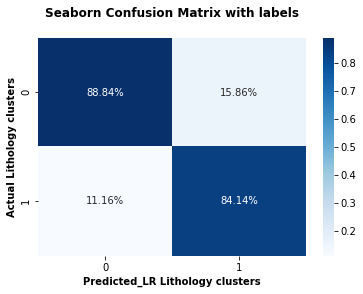

In [70]:
from sklearn.metrics import confusion_matrix

# Generating the confusion matrix
cf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

ax = sns.heatmap(cf_matrix_lr/cf_matrix_lr.sum(axis=0), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n', fontweight='bold');
ax.set_xlabel('Predicted_LR Lithology clusters', fontweight='bold')
ax.set_ylabel('Actual Lithology clusters', fontweight='bold');

plt.show()

## Deep Learning (MLP)

In [71]:
mlp_model = MLPClassifier(solver='adam',
                          activation = 'relu',
                          hidden_layer_sizes = (100, 50, 20),
                          learning_rate = 'adaptive'
                         )
                
mlp_model = mlp_model.fit(X_train, y_train)

y_pred_mlp = mlp_model.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_mlp))

C:\Users\Sir_Praise\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       543
           2       0.98      1.00      0.99       819

    accuracy                           0.99      1362
   macro avg       0.99      0.99      0.99      1362
weighted avg       0.99      0.99      0.99      1362



In [72]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred_mlp)

0.9889867841409692

In [73]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_test, y_pred_mlp)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.9962406  0.98433735]
recall: [0.97605893 0.997558  ]
fscore: [0.98604651 0.99090358]
support: [543 819]


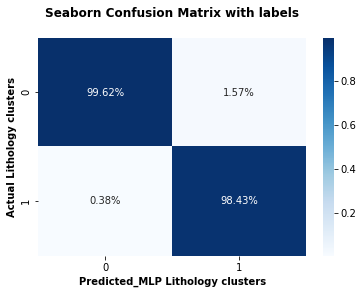

In [74]:
from sklearn.metrics import confusion_matrix

# Generating the confusion matrix
cf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

ax = sns.heatmap(cf_matrix_mlp/cf_matrix_mlp.sum(axis=0), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n', fontweight='bold');
ax.set_xlabel('Predicted_MLP Lithology clusters', fontweight='bold')
ax.set_ylabel('Actual Lithology clusters', fontweight='bold');

plt.show()

# Random Forest Model

In [75]:
rf_model =RandomForestClassifier(criterion = 'gini',
                                 random_state=42,
                                 max_depth = 7,
                                 max_features = 'sqrt',
                                 n_estimators = 200,
                                 class_weight = 'balanced_subsample'
                                )


rf_model = rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf))

C:\Users\Sir_Praise\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       543
           2       1.00      1.00      1.00       819

    accuracy                           1.00      1362
   macro avg       1.00      1.00      1.00      1362
weighted avg       1.00      1.00      1.00      1362



In [76]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_test, y_pred_rf)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.99631676 0.997558  ]
recall: [0.99631676 0.997558  ]
fscore: [0.99631676 0.997558  ]
support: [543 819]


In [78]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred_rf)

0.9970631424375918

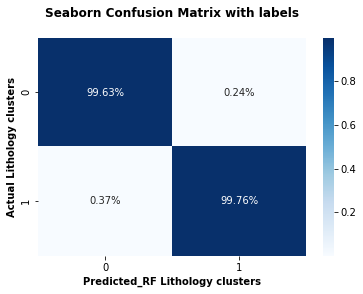

In [79]:
from sklearn.metrics import confusion_matrix

# Generating the confusion matrix
cf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

ax = sns.heatmap(cf_matrix_rf/cf_matrix_rf.sum(axis=0), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n', fontweight='bold');
ax.set_xlabel('Predicted_RF Lithology clusters', fontweight='bold')
ax.set_ylabel('Actual Lithology clusters', fontweight='bold');

plt.show()

# Voting Classifier

In [98]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier


# initialize voting classifier
eclf = VotingClassifier(
    estimators=[('mlp', mlp_model), ('rf', rf_model), ('lr', lr_model)],
    voting='hard')

# fit the models
eclf = eclf.fit(X_train, y_train)


# predict the lithology
y_pred = eclf.predict(X_test)

# df_actual = drill_merged.Lithology
# df_Lithology_Pred = Lithology_Pred

C:\Users\Sir_Praise\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sir_Praise\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [99]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       543
           2       0.98      1.00      0.99       819

    accuracy                           0.99      1362
   macro avg       0.99      0.98      0.99      1362
weighted avg       0.99      0.99      0.99      1362



In [100]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.99810606 0.98081535]
recall: [0.97053407 0.998779  ]
fscore: [0.98412698 0.98971567]
support: [543 819]


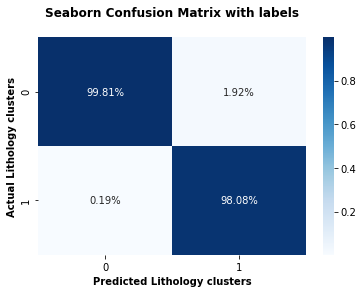

In [101]:
from sklearn.metrics import confusion_matrix

# Generating the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix/cf_matrix.sum(axis=0), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n', fontweight='bold');
ax.set_xlabel('Predicted Lithology clusters', fontweight='bold')
ax.set_ylabel('Actual Lithology clusters', fontweight='bold');

plt.show()

In [102]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9875183553597651

# Prediction on Test Data

Note: X_15 represents the scaled testing data and y_15 for the labeled testing data

In [103]:
X_15 = MinMax(df_test.iloc[:, :-1])

In [104]:
y_15 = df_test.iloc[:, -1:]

## 1. Logistic Regression

In [105]:
y_lr15 = lr_model.predict(X_15)
print(classification_report(y_15, y_lr15))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       250
           2       1.00      0.86      0.92       250

    accuracy                           0.93       500
   macro avg       0.94      0.93      0.93       500
weighted avg       0.94      0.93      0.93       500



In [106]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_15, y_lr15)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.87412587 1.        ]
recall: [1.    0.856]
fscore: [0.93283582 0.92241379]
support: [250 250]


In [107]:
accuracy_score(y_15, y_lr15)

0.928

## 2. MLP

In [108]:
y_mlp15 = mlp_model.predict(X_15)
print(classification_report(y_15, y_mlp15))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       250
           2       1.00      0.90      0.94       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



In [109]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_15, y_mlp15)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.90545455 0.99555556]
recall: [0.996 0.896]
fscore: [0.94857143 0.94315789]
support: [250 250]


In [110]:
accuracy_score(y_15, y_mlp15)

0.946

# 3. Random Forest

In [111]:
y_rf15 = rf_model.predict(X_15)
print(classification_report(y_15, y_rf15))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       250
           2       0.99      0.92      0.95       250

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



In [112]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_15, y_rf15)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.92537313 0.99137931]
recall: [0.992 0.92 ]
fscore: [0.95752896 0.95435685]
support: [250 250]


In [113]:
accuracy_score(y_15, y_rf15)

0.956

## 4. Voting 

In [114]:
y_vt15 = eclf.predict(X_15)
print(classification_report(y_15, y_vt15))

              precision    recall  f1-score   support

           0       0.92      1.00      0.95       250
           2       1.00      0.91      0.95       250

    accuracy                           0.95       500
   macro avg       0.96      0.95      0.95       500
weighted avg       0.96      0.95      0.95       500



In [115]:
accuracy_score(y_15, y_vt15)

0.952

In [116]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_15, y_vt15)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.91544118 0.99561404]
recall: [0.996 0.908]
fscore: [0.95402299 0.94979079]
support: [250 250]


## Note: The evaluation plots can be seen in the testing notebook, 

# End !